# RegularNet

In [1]:
#Load necessary libraries
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim
import input_data
import matplotlib.pyplot as plt
%matplotlib inline

### Load CIFAR Dataset

To obtain the CIFAR10 dataset, go here: https://www.cs.toronto.edu/~kriz/cifar.html

The training data is stored in 5 separate files, and we will alternate between them during training.

In [7]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def ConvertImages(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, 3, 32, 32])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images

In [3]:
currentCifar = 1
cifar = unpickle('./cifar10/data_batch_1')
cifarT = unpickle('./cifar10/test_batch')

In [4]:
total_layers = 25 #Specify how deep we want our network
units_between_stride = total_layers / 5

## RegularNet
A Deep Neural Network composed exclusively of regular and strided convolutional layers. While this architecture works well for relatively shallow networks, it becomes increasingly more difficult to train as the network depth increases.

In [5]:
tf.reset_default_graph()

input_layer = tf.placeholder(shape=[None,32,32,3],dtype=tf.float32,name='input')
label_layer = tf.placeholder(shape=[None],dtype=tf.int32)
label_oh = slim.layers.one_hot_encoding(label_layer,10)

layer1 = slim.conv2d(input_layer,64,[3,3],normalizer_fn=slim.batch_norm,scope='conv_'+str(0))
for i in range(5):
    for j in range(units_between_stride):
        layer1 = slim.conv2d(layer1,64,[3,3],normalizer_fn=slim.batch_norm,scope='conv_'+str((j+1) + (i*units_between_stride)))
    layer1 = slim.conv2d(layer1,64,[3,3],stride=[2,2],normalizer_fn=slim.batch_norm,scope='conv_s_'+str(i))
    
top = slim.conv2d(layer1,10,[3,3],normalizer_fn=slim.batch_norm,activation_fn=None,scope='conv_top')

output = slim.layers.softmax(slim.layers.flatten(top))

loss = tf.reduce_mean(-tf.reduce_sum(label_oh * tf.log(output) + 1e-10, axis=[1]))
trainer = tf.train.AdamOptimizer(learning_rate=0.001)
update = trainer.minimize(loss)

### Visualize the network graph
We can call the Tensorflow Board to provide a graphical representation of our network.

In [6]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [8]:
show_graph(tf.get_default_graph().as_graph_def())

## Training

In [11]:
init = tf.global_variables_initializer()
batch_size = 64
currentCifar = 1
total_steps = 20000
l = []
a = []
aT = []
saver = tf.train.Saver()
sess = tf.Session()
sess.run(init)
i = 0
draw = range(10000)
while i < total_steps:
    if i % (10000/batch_size) != 0:
        batch_index = np.random.choice(draw,size=batch_size,replace=False)
    else:
        draw = range(10000)
        if currentCifar == 5:
            currentCifar = 1
            print "Switched CIFAR set to " + str(currentCifar)
        else:
            currentCifar = currentCifar + 1
            print "Switched CIFAR set to " + str(currentCifar)
        cifar = unpickle('./cifar10/data_batch_'+str(currentCifar))
        batch_index = np.random.choice(draw,size=batch_size,replace=False)
    x = ConvertImages(cifar['data'][batch_index])  
    y = np.reshape(np.array(cifar['labels'])[batch_index],[batch_size,1])
    _,lossA,yP,LO = sess.run([update,loss,output,label_oh],feed_dict={input_layer:x,label_layer:np.hstack(y)})
    accuracy = np.sum(np.equal(np.hstack(y),np.argmax(yP,1)))/float(len(y))
    l.append(lossA)
    a.append(accuracy)
    if i % 10 == 0: print "Step: " + str(i) + " Loss: " + str(lossA) + " Accuracy: " + str(accuracy)
    if i % 100 == 0: 
        point = np.random.randint(0,10000-500)
        xT = ConvertImages(cifarT['data'][point:point+500]) 
        yT = np.reshape(np.array(cifarT['labels'])[point:point+500],[500])
        lossT,yP = sess.run([loss,output],feed_dict={input_layer:xT,label_layer:yT})
        accuracy = np.sum(np.equal(yT,np.argmax(yP,1)))/float(len(yT))
        aT.append(accuracy)
        print "Test set accuracy: " + str(accuracy)
    i+= 1
save_path = saver.save(sess, "./trainingmodels/model_regularnet.ckpt")
print "Model saved in file: " + str(save_path)
sess.close()

Switched CIFAR set to 2
Step: 0 Loss: 2.64318 Accuracy: 0.09375


KeyboardInterrupt: 

## Results

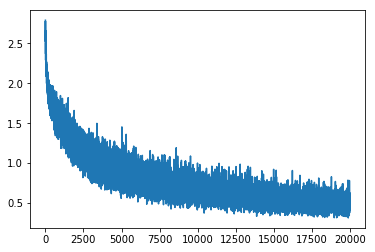

In [8]:
plt.plot(l) #Plot training loss

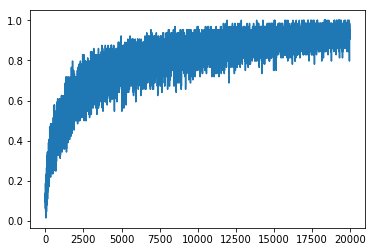

In [9]:
plt.plot(a) #Plot training accuracy

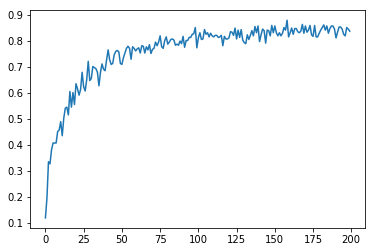

In [10]:
plt.plot(aT) #Plot test accuracy

In [10]:
np.max(aT) #Best test accuracy

NameError: name 'aT' is not defined

In [12]:
# Calculate test accuracy
def CalcTestAccuracy(sess, data, labels, isTransformed):
    yT = np.reshape(np.array(labels),[len(labels)])
    if(isTransformed):
        lossT,yP = sess.run([loss,output],feed_dict={input_layer:data.eval(),label_layer:yT})
    else:
        lossT,yP = sess.run([loss,output],feed_dict={input_layer:data,label_layer:yT})
    accuracy = np.sum(np.equal(yT,np.argmax(yP,1)))/float(len(yT))
    print "Test set accuracy: " + str(accuracy)
    return accuracy


Model restored.
Test set accuracy: 0.158


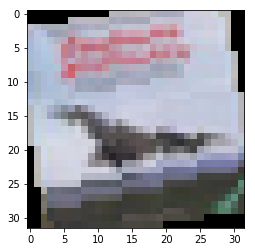

Test set accuracy: 0.126


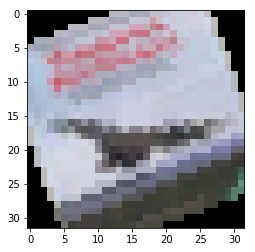

Test set accuracy: 0.066


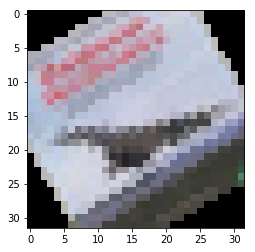

Test set accuracy: 0.064


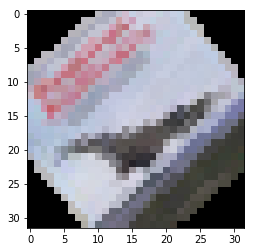

Test set accuracy: 0.058


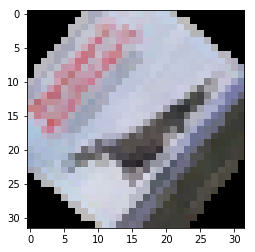

Test set accuracy: 0.07


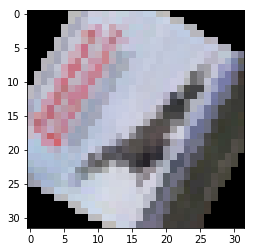

Test set accuracy: 0.076


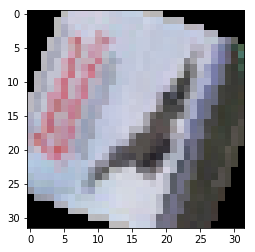

Test set accuracy: 0.096


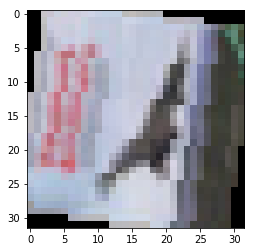

Test set accuracy: 0.226


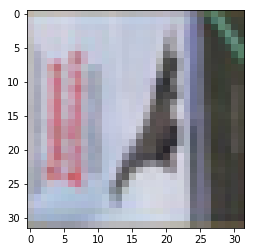

Test set accuracy: 0.266


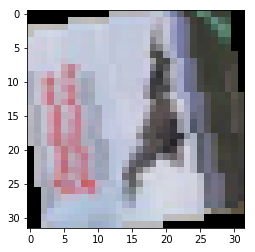

Test set accuracy: 0.198


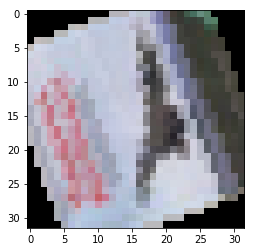

Test set accuracy: 0.092


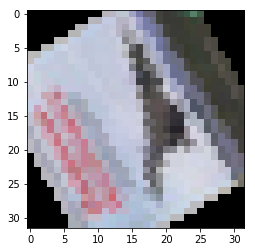

Test set accuracy: 0.068


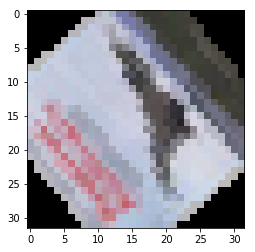

Test set accuracy: 0.056


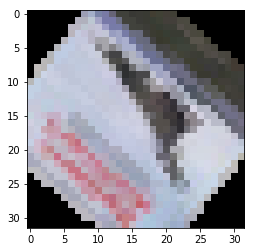

Test set accuracy: 0.064


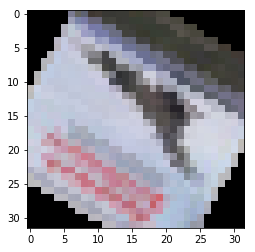

Test set accuracy: 0.046


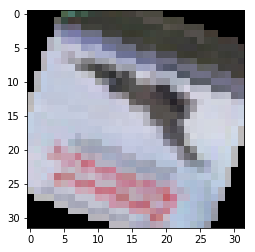

Test set accuracy: 0.072


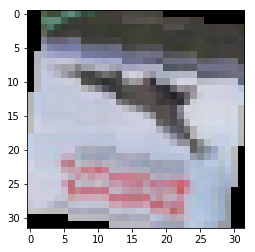

Test set accuracy: 0.138


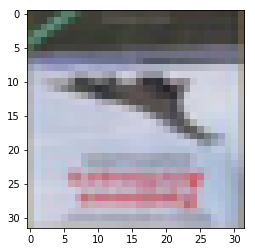

Test set accuracy: 0.172


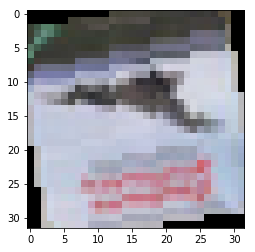

Test set accuracy: 0.122


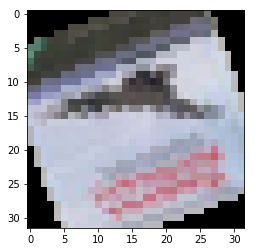

Test set accuracy: 0.066


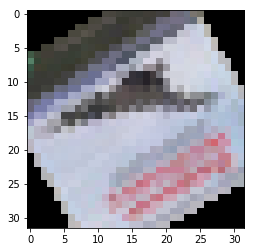

Test set accuracy: 0.048


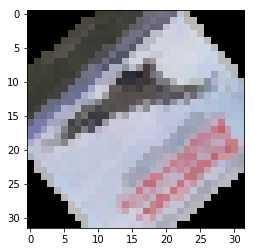

Test set accuracy: 0.062


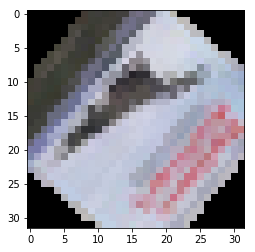

Test set accuracy: 0.074


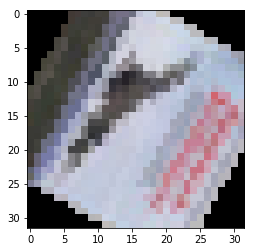

Test set accuracy: 0.064


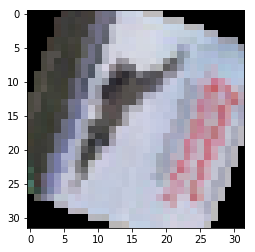

Test set accuracy: 0.09


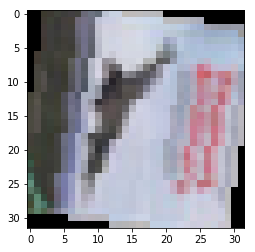

Test set accuracy: 0.162


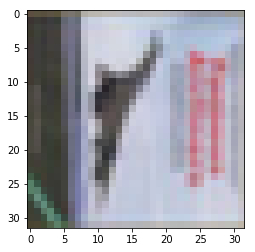

Test set accuracy: 0.182


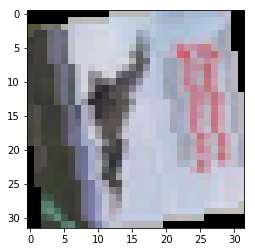

Test set accuracy: 0.11


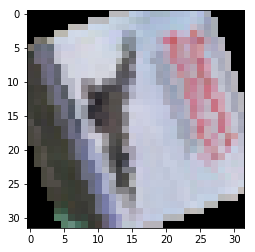

Test set accuracy: 0.068


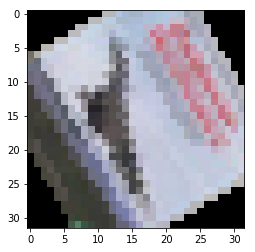

Test set accuracy: 0.06


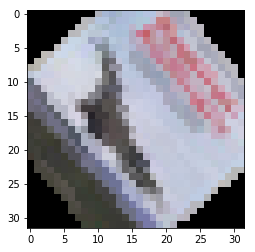

Test set accuracy: 0.046


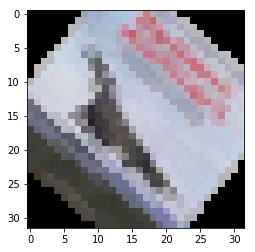

Test set accuracy: 0.052


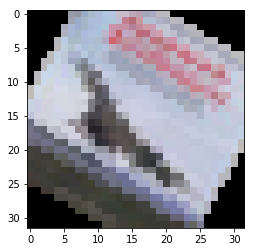

Test set accuracy: 0.056


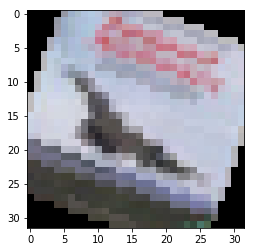

Test set accuracy: 0.072


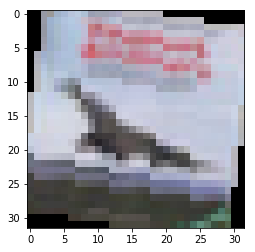

Test set accuracy: 0.138


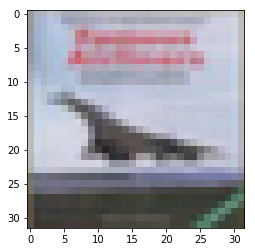

Test set accuracy: 0.158


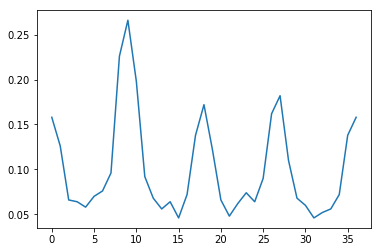

In [13]:
#Get 500 images with the same label
label = 0 #label value 0-9
numbOfImg = 500 #Number of images to be found
currImg = 0
index = 0

images = []
labels = []

while currImg < numbOfImg:
    if cifarT['labels'][index] == label:
        images.append(cifarT['data'][index])
        labels.append(cifarT['labels'][index])
        currImg += 1
    index += 1

#Original position
#origImages = tf.contrib.image.rotate(ConvertImages(images), 1.571)

#Resize image
#resImage = tf.image.resize_image_with_crop_or_pad(ConvertImages(images)[0], 16, 16)


#print rotImages
#plt.imshow(np.reshape(ConvertImages(images)[0],(32,32,3), order='F'))
#plt.show()
np.seterr(divide='ignore', invalid='ignore')
saver = tf.train.Saver()

#List with all accuracies
accList = []

with tf.Session() as sess:
    saver.restore(sess, "./trainingmodels/model_regularnet.ckpt")
    print "Model restored."
    rotAngle = 10
    curAngle = 10
    
    #First run for original image
    accList.append(CalcTestAccuracy(sess, ConvertImages(images), labels, False))
    
    #Rotate 10 degree
    while curAngle < 360:
        rotImages = tf.contrib.image.rotate(ConvertImages(images), np.radians(curAngle))
        
        #print first rotated image
        plt.imshow(np.reshape(rotImages.eval()[0],(32,32,3), order='F'))
        plt.show()
        
        #Calc accuracy for the rotated images
        accList.append(CalcTestAccuracy(sess, rotImages, labels, True))
        
        #Increment or curAngle with +rotAngle
        curAngle += rotAngle
        

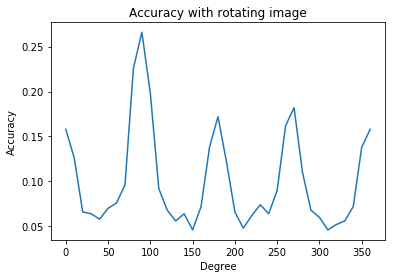

In [29]:
#Plot our accuracies
x = np.arange(0, 360, 10)
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.title('Accuracy with rotating image')
plt.plot(x,accList)
plt.show()